# Proyecto Talento TECH - Pronosticos de demanda

### Contenido de cada columna:
- PAÍS: Nombre del país
- CODE_TIME: Un código que representa el mes y el año (p. ej., JAN2010 para enero de 2010)
- TIME: El mes y el año en un formato más legible para humanos (p. ej., enero de 2010)
- YEAR: El año del punto de datos
- MONTH: El mes del punto de datos como un número (1-12)
- MONTH_NAME: El mes del punto de datos como una cadena (p. ej., enero)
- PRODUCT: El tipo de producto energético (p. ej., hidroeléctrico, eólico, solar)
- VALUE: La cantidad de electricidad generada en gigavatios-hora (GWh)
- DISPLAY_ORDER: El orden en el que se deben mostrar los productos
- yearToDate: La cantidad de electricidad generada durante el año actual hasta el mes actual en GWh
- previousYearToDate: La cantidad de electricidad generada durante el año anterior hasta el mes actual en GWh
- share: La participación del producto en la generación total de electricidad para el país en formato decimal

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



ModuleNotFoundError: No module named 'seaborn'

In [ ]:
from google.colab import files
upload= files.upload()

Saving databproduction.csv to databproduction.csv


In [ ]:
# Cargar el archivo con el delimitador correcto (;)
file_path = "databproduction.csv"
df = pd.read_csv(file_path, delimiter=";")
df.head()

,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
0,Australia,JAN2010,January 2010,2010,1,January,Hydro,990.728,1,16.471.891,NaN,0.04777072935264173
1,Australia,JAN2010,January 2010,2010,1,January,Wind,409.469,2,4.940.909,NaN,0.01974369632966552
2,Australia,JAN2010,January 2010,2010,1,January,Solar,49.216,3,908.238,NaN,0.0023730874829616362
3,Australia,JAN2010,January 2010,2010,1,January,Geothermal,0.083,4,0.996,NaN,"4,00E+09"
4,Australia,JAN2010,January 2010,2010,1,January,Total combustible fuels,19289.73,7,214.302.969,NaN,0.9301084365391247


In [ ]:
df.dtypes

,0
COUNTRY,object
CODE_TIME,object
TIME,object
YEAR,int64
MONTH,int64
MONTH_NAME,object
PRODUCT,object
VALUE,object
DISPLAY_ORDER,int64
yearToDate,object


# Variable objetivo "Value"
- Conversión de variables Object a númerica
- Imputación de datos faltantes


In [ ]:
def convert_to_numeric(column):
    return column.astype(str).str.replace(".", "", regex=False).str.replace(",", ".").astype(float)
numeric_columns = ["VALUE", "yearToDate", "previousYearToDate", "share"]
for col in numeric_columns:
    df[col] = convert_to_numeric(df[col])

In [ ]:
# Eliminar valores negativos en VALUE que no sean de "Electricity trade"
df_clean = df[~((df["VALUE"] < 0) & (df["PRODUCT"] != "Electricity trade"))].copy()

# Detectar valores atípicos (percentil 99.5)
threshold = df_clean["VALUE"].quantile(0.995)

# Opcional: Filtrar valores extremadamente altos si deseas eliminarlos
df_clean = df_clean[df_clean["VALUE"] <= threshold]

# Guardar el dataset limpio
df_clean.to_csv("databproduction_clean.csv", index=False)

print("Limpieza completada. Archivo guardado como 'databproduction_clean.csv'.")

Limpieza completada. Archivo guardado como 'databproduction_clean.csv'.


In [ ]:
df_clean.dtypes


,0
COUNTRY,object
CODE_TIME,object
TIME,object
YEAR,int64
MONTH,int64
MONTH_NAME,object
PRODUCT,object
VALUE,float64
DISPLAY_ORDER,int64
yearToDate,float64


In [ ]:
df_clean.shape

(180920, 12)

In [ ]:
# Codificar la columna COUNTRY en valores numéricos
encoder = LabelEncoder()
df["COUNTRY_encoded"] = encoder.fit_transform(df["COUNTRY"])

Text(0.5, 1.0, 'Datos faltantes')

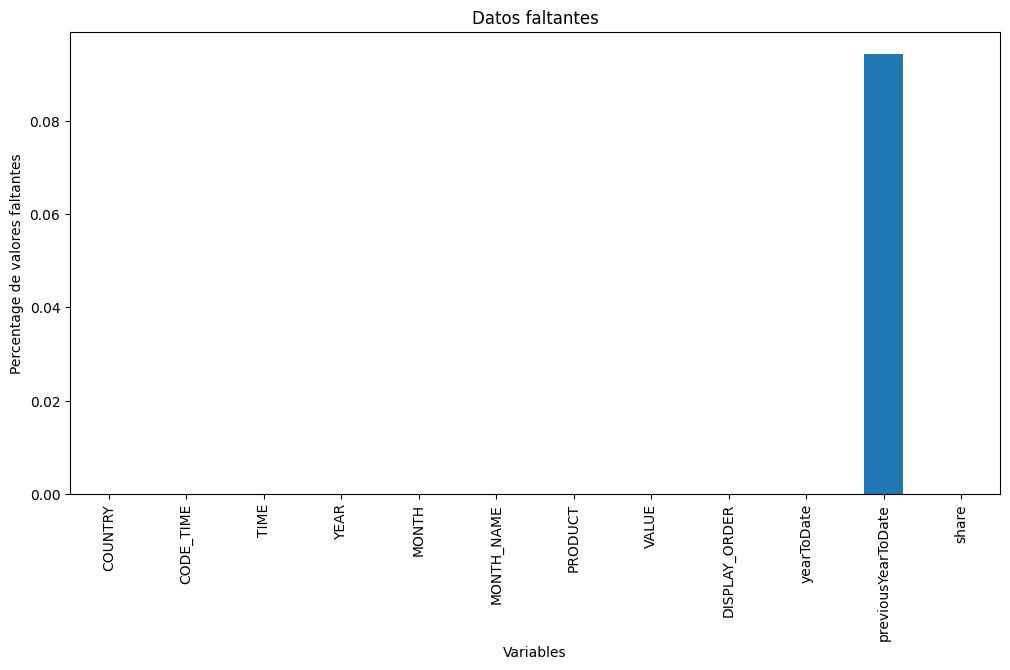

In [ ]:
df_clean.isnull().sum()

# Alternativamente podemos usar mean() con isnull() para visualizar el porcentaje de varoleres faltantes en cada variable
df_clean.isnull().mean()

# Podemos tambien graficar el porcentaje de valores faltantes con
# pandas plot.bar()

df_clean.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage de valores faltantes')
plt.xlabel('Variables')
plt.title('Datos faltantes')

# Filtrar datos a solo Colombia, Estados Unidos y Brazil

In [ ]:
# Filtrar solo los países deseados
df_filtered = df_clean[df_clean["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]
df_filtered["COUNTRY"].value_counts()


,count
COUNTRY,
United States,4104
Colombia,2548
Brazil,2328


In [ ]:
df_filtered.head()

,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
940,United States,JAN2010,January 2010,2010,1,January,Hydro,2428386.0,1,284270.0,NaN,6.666426e+15
941,United States,JAN2010,January 2010,2010,1,January,Wind,6964964.0,2,94651999.0,NaN,1.912028e+15
942,United States,JAN2010,January 2010,2010,1,January,Solar,28868.0,3,3847998.0,NaN,7.920000e+10
943,United States,JAN2010,January 2010,2010,1,January,Geothermal,1333378.0,4,15219001.0,NaN,3.660401e+16
944,United States,JAN2010,January 2010,2010,1,January,Nuclear,72569314.0,6,806968001.0,NaN,1.992179e+16


<ipython-input-44-a08f5bbe97f3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered, palette="Set2")


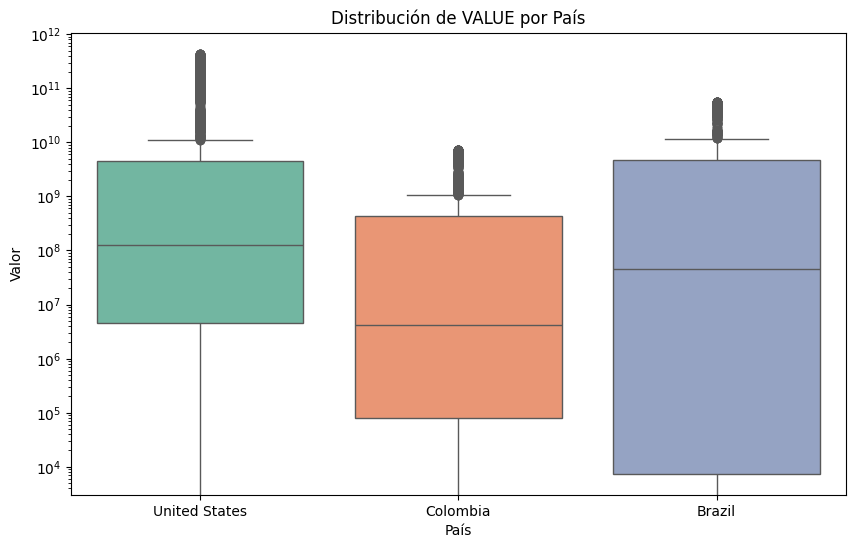

In [ ]:
# Filtrar los datos solo para Colombia, Brasil y Estados Unidos
df_filtered = df[df["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]

# Crear un boxplot para visualizar la distribución de VALUE por país
plt.figure(figsize=(10, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered, palette="Set2")

# Configuración de la gráfica
plt.title("Distribución de VALUE por País")
plt.xlabel("País")
plt.ylabel("Valor")
plt.yscale("log")  # Escala logarítmica si los valores tienen mucha variación
plt.show()

In [ ]:
num_unique_products = df["PRODUCT"].nunique()

# Obtener la lista completa de valores únicos
unique_products = df["PRODUCT"].unique()

# Mostrar resultados
print(f"Cantidad de valores únicos en 'PRODUCT': {num_unique_products}")
print("Lista de valores únicos:")
print(unique_products)

Cantidad de valores únicos en 'PRODUCT': 27
Lista de valores únicos:
['Hydro' 'Wind' 'Solar' 'Geothermal' 'Total combustible fuels' 'Coal'
 'Oil' 'Natural gas' 'Combustible renewables' 'Net electricity production'
 'Electricity supplied' 'Used for pumped storage' 'Distribution losses'
 'Final consumption' 'Renewables' 'Non-renewables' 'Others'
 'Other renewables aggregated' 'Low carbon' 'Fossil fuels'
 'Other combustible non-renewables' 'Not specified' 'Total imports'
 'Total exports' 'Electricity trade' 'Nuclear' 'Other renewables']


Grafica de "Value" por país y tipo de generación eléctrica

<ipython-input-64-59a7c3e38ac8>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)


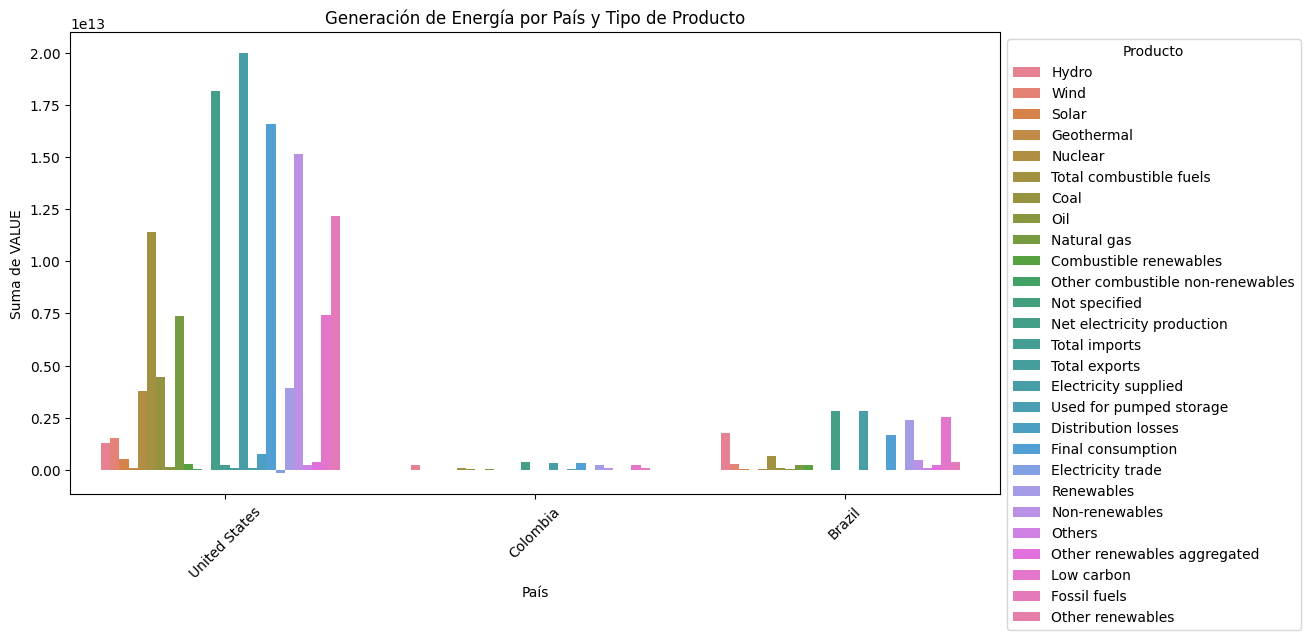

In [ ]:
# Filtrar solo los países de interés
df_filtered = df[df["COUNTRY"].isin(["Colombia", "Brazil", "United States"])]

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)

# Configuración de la gráfica
plt.title("Generación de Energía por País y Tipo de Producto")
plt.xlabel("País")
plt.ylabel("Suma de VALUE")
plt.legend(title="Producto", bbox_to_anchor=(1, 1))  # Mueve la leyenda fuera para mejor visualización
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

# Transformación Logaritmica para ver mejor los datos

<ipython-input-94-4d02d7d3107e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)


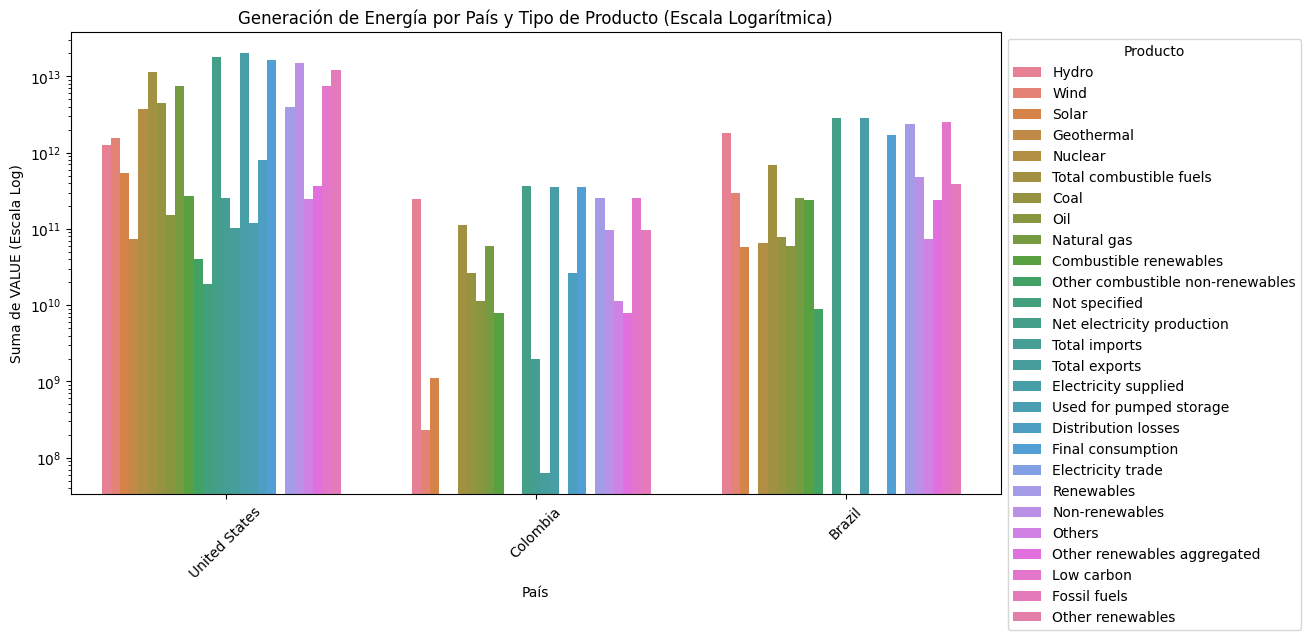

In [ ]:
# Crear la gráfica de barras con escala logarítmica
plt.figure(figsize=(12, 6))
sns.barplot(x="COUNTRY", y="VALUE", hue="PRODUCT", data=df_filtered, estimator=sum, ci=None)

# Aplicar escala logarítmica en el eje Y
plt.yscale("log")

# Configuración de la gráfica
plt.title("Generación de Energía por País y Tipo de Producto (Escala Logarítmica)")
plt.xlabel("País")
plt.ylabel("Suma de VALUE (Escala Log)")
plt.legend(title="Producto", bbox_to_anchor=(1, 1))  # Mueve la leyenda fuera para mejor visualización
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

Correlación con COUNTRY:
COUNTRY_encoded       1.000000
yearToDate            0.195707
VALUE                 0.189524
previousYearToDate    0.152094
share                 0.080199
DISPLAY_ORDER         0.019640
PRODUCT_encoded       0.015683
MONTH                 0.000207
YEAR                 -0.326722
Name: COUNTRY_encoded, dtype: float64

Correlación con PRODUCT:
PRODUCT_encoded       1.000000
share                 0.065421
COUNTRY_encoded       0.015683
YEAR                  0.010839
MONTH                 0.000051
previousYearToDate   -0.088487
yearToDate           -0.099100
VALUE                -0.110250
DISPLAY_ORDER        -0.133396
Name: PRODUCT_encoded, dtype: float64


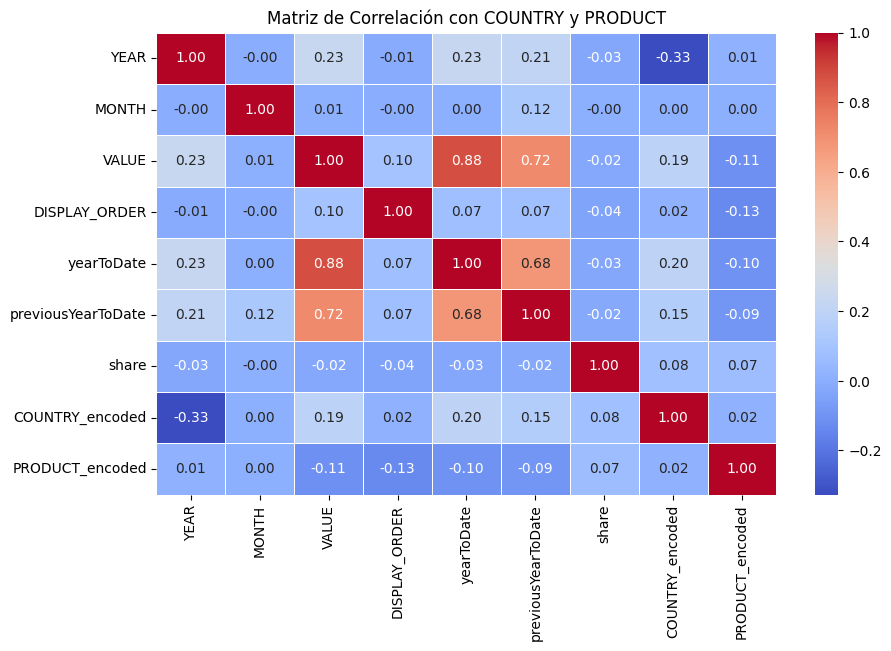

In [ ]:
# Codificar las columnas COUNTRY y PRODUCT a valores numéricos
encoder_country = LabelEncoder()
encoder_product = LabelEncoder()

df_filtered["COUNTRY_encoded"] = encoder_country.fit_transform(df_filtered["COUNTRY"])
df_filtered["PRODUCT_encoded"] = encoder_product.fit_transform(df_filtered["PRODUCT"])

# Calcular la matriz de correlación
corr_matrix = df_filtered.corr(numeric_only=True)

# Extraer solo la correlación con "COUNTRY_encoded" y "PRODUCT_encoded"
corr_with_country = corr_matrix["COUNTRY_encoded"].sort_values(ascending=False)
corr_with_product = corr_matrix["PRODUCT_encoded"].sort_values(ascending=False)

# Mostrar las correlaciones más altas
print("Correlación con COUNTRY:")
print(corr_with_country)

print("\nCorrelación con PRODUCT:")
print(corr_with_product)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación con COUNTRY y PRODUCT")
plt.show()

plt.show()

Se elimina la columna "code_time", ya que se considera poco relevante

In [ ]:
df_filtered.drop(columns=["CODE_TIME"], inplace=True, errors="ignore")


In [ ]:
df_filtered.head()

,COUNTRY,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share,COUNTRY_encoded,PRODUCT_encoded
940,United States,January 2010,2010,1,January,Hydro,2428386.0,1,284270.0,NaN,6.666426e+15,2,8
941,United States,January 2010,2010,1,January,Wind,6964964.0,2,94651999.0,NaN,1.912028e+15,2,26
942,United States,January 2010,2010,1,January,Solar,28868.0,3,3847998.0,NaN,7.920000e+10,2,21
943,United States,January 2010,2010,1,January,Geothermal,1333378.0,4,15219001.0,NaN,3.660401e+16,2,7
944,United States,January 2010,2010,1,January,Nuclear,72569314.0,6,806968001.0,NaN,1.992179e+16,2,14


In [ ]:
# Definir función para detectar outliers usando el rango intercuartil (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)  # Primer cuartil
    Q3 = df[columna].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartil
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

# Detectar outliers en VALUE por país y producto dentro de df_filtered
for pais in df_filtered["COUNTRY"].unique():
    for producto in df_filtered["PRODUCT"].unique():
        df_filtrado = df_filtered[(df_filtered["COUNTRY"] == pais) & (df_filtered["PRODUCT"] == producto)]
        outliers = detectar_outliers(df_filtrado, "VALUE")

        if not outliers.empty:
            print(f"Outliers en {pais} - {producto}:")
            print(outliers[["COUNTRY", "PRODUCT", "VALUE"]], "\n")


Outliers en United States - Solar:
              COUNTRY PRODUCT         VALUE
172668  United States   Solar  1.754040e+10
173823  United States   Solar  1.970431e+10
174978  United States   Solar  2.070308e+10
176133  United States   Solar  2.037332e+10
177287  United States   Solar  1.859066e+10
178442  United States   Solar  1.743742e+10 

Outliers en United States - Oil:
              COUNTRY PRODUCT         VALUE
103066  United States     Oil  8.605433e+09
181896  United States     Oil  7.130296e+09 

Outliers en United States - Not specified:
              COUNTRY        PRODUCT         VALUE
162435  United States  Not specified  1.204946e+09 

Outliers en United States - Total exports:
              COUNTRY        PRODUCT         VALUE
119597  United States  Total exports  3.465578e+09
120974  United States  Total exports  3.936460e+09
122351  United States  Total exports  4.830144e+09
123728  United States  Total exports  4.776011e+09
125105  United States  Total exports  4.070

In [ ]:
# Ver cuántos valores nulos tiene cada columna
print(df_filtered.isnull().sum())

# Imputar valores numéricos con la mediana
df_filtered.fillna(df_filtered.median(numeric_only=True), inplace=True)

# Imputar valores categóricos con la moda
for col in df_filtered.select_dtypes(include=['object']):
    df_filtered[col].fillna(df_filtered[col].mode()[0], inplace=True)


COUNTRY                 0
TIME                    0
YEAR                    0
MONTH                   0
MONTH_NAME              0
PRODUCT                 0
VALUE                   0
DISPLAY_ORDER           0
yearToDate              0
previousYearToDate    975
share                   0
COUNTRY_encoded         0
PRODUCT_encoded         0
dtype: int64


<ipython-input-98-819ada94b752>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col].fillna(df_filtered[col].mode()[0], inplace=True)


### analisis de la distribución de Value por Pais para saber si hay cesgos

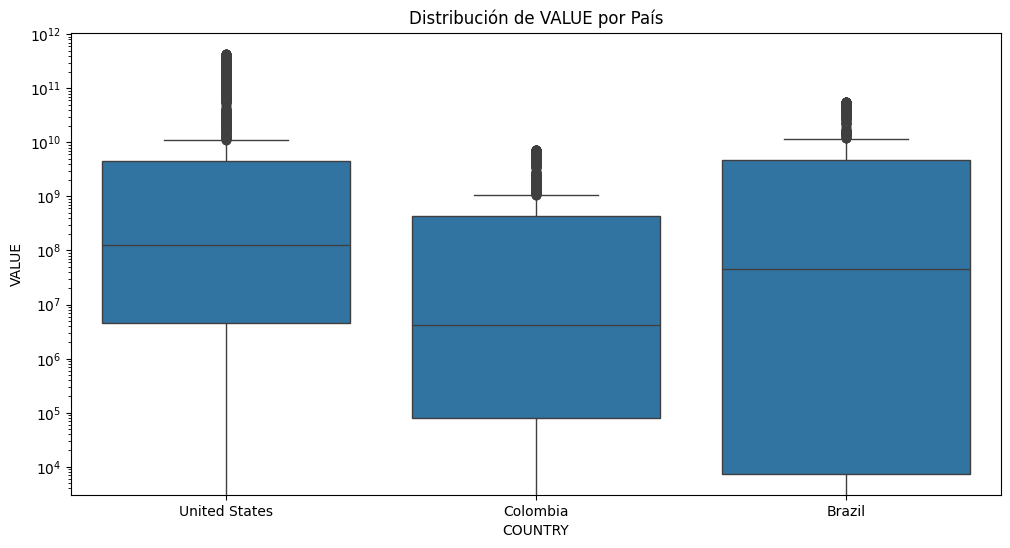

In [ ]:


plt.figure(figsize=(12, 6))
sns.boxplot(x="COUNTRY", y="VALUE", data=df_filtered)
plt.title("Distribución de VALUE por País")
plt.yscale("log")
plt.show()


## normalizacion de los datos de produccion de energia( value)
con esto evitamos que los datos mas alejados dominen los precesos de aprendizaje debido a la diferencia de tan amplia en los valores de United States respecto de Colombia y Brazil lo que hacemos es normalizar los valores por separado para cada pais para no comprimir demasiado a los de USA


## Modelo de regresion lineal
este modelo resulta viable ya que podemos observar en los datos un modesto patron en algunos intervalos  de linealidad en los datos, sin embargo  nestras variables independientes no determinan directamente el valor de la producion energetica solo la variable de mesese y años que son de tiempo

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Encode 'COUNTRY' and 'PRODUCT' before scaling
encoder_country = LabelEncoder()
encoder_product = LabelEncoder()

df_filtered["COUNTRY_encoded"] = encoder_country.fit_transform(df_filtered["COUNTRY"])
df_filtered["PRODUCT_encoded"] = encoder_product.fit_transform(df_filtered["PRODUCT"])

# Perform scaling while keeping encoded columns
df_list = []
for country in ['Colombia', 'Brazil', 'United States']:
    temp = df_filtered[df_filtered['COUNTRY'] == country].copy()
    scaler = MinMaxScaler()
    # Only scale the 'VALUE' column
    temp['VALUE'] = scaler.fit_transform(temp[['VALUE']])
    df_list.append(temp)

df_filtered_scaled = pd.concat(df_list)

# Features and Target
X = df_filtered_scaled[['COUNTRY_encoded', 'PRODUCT_encoded', 'YEAR', 'MONTH']]
y = df_filtered_scaled['VALUE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"R-cuadrado (R2): {r2}")

Error Cuadrático Medio (MSE): 0.045734808572525265
R-cuadrado (R2): 0.15757672153186308


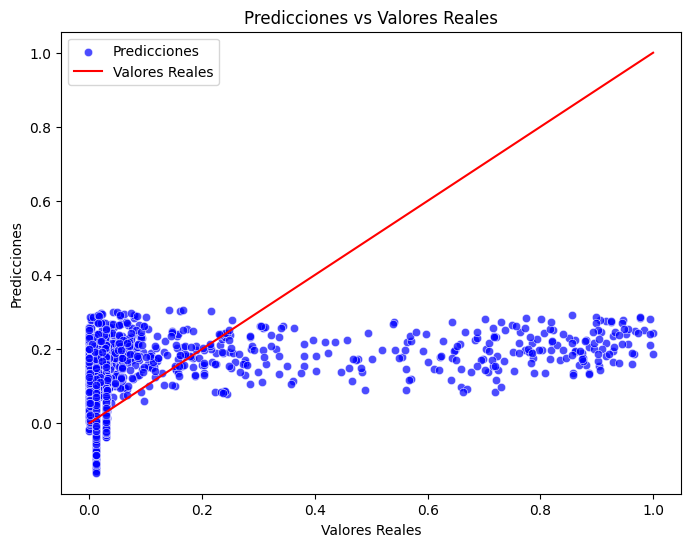

In [ ]:
# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='blue', label='Predicciones')
sns.lineplot(x=y_test, y=y_test, color='red', label='Valores Reales')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.legend()
plt.show()

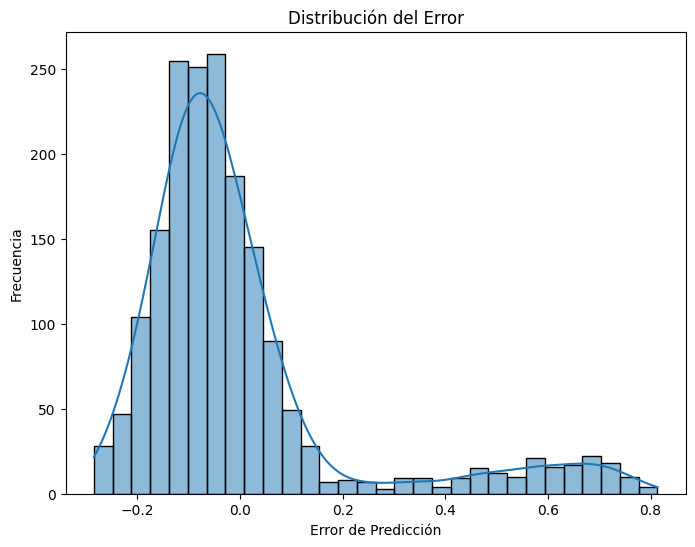

In [ ]:
# Visualizar la distribución del error (diferencia entre predicción y realidad)
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_pred, bins=30, kde=True)
plt.xlabel("Error de Predicción")
plt.ylabel("Frecuencia")
plt.title("Distribución del Error")
plt.show()

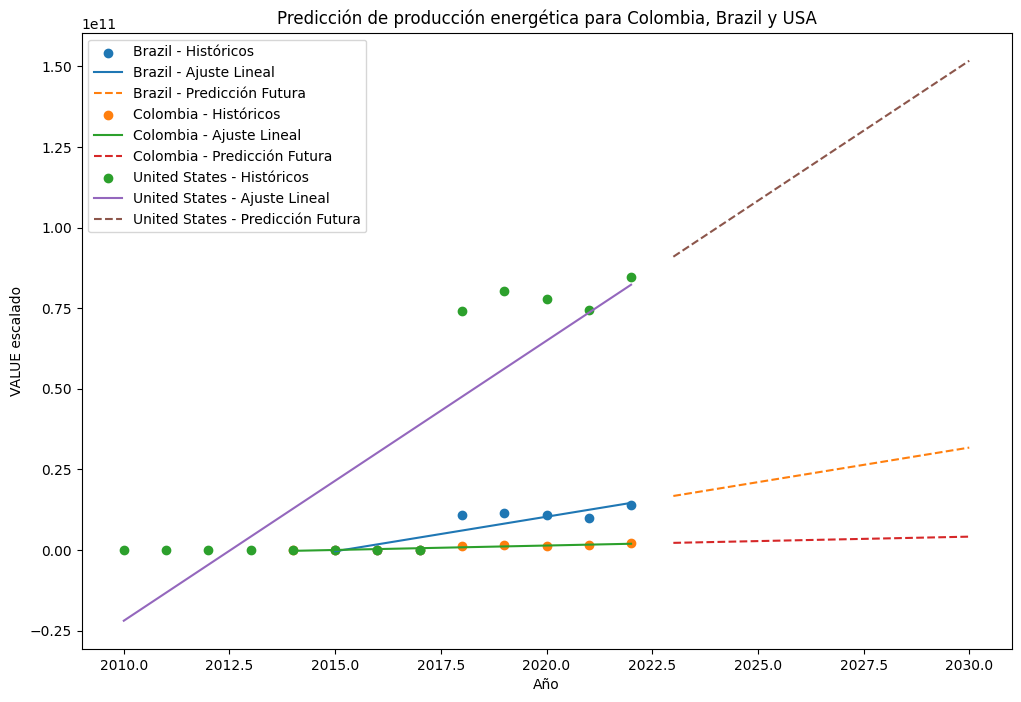

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression



# Agregar por país y año: calculamos el promedio de VALUE para cada año
df_agg = df_filtered.groupby(['COUNTRY', 'YEAR'])['VALUE'].mean().reset_index()

# Crear diccionarios para almacenar modelos y predicciones
modelos = {}
predicciones = {}

# Definir los años futuros a predecir, por ejemplo desde el año máximo registrado hasta 2030
ano_maximo = df_agg['YEAR'].max()
anos_futuros = np.arange(ano_maximo + 1, 2031)

plt.figure(figsize=(12, 8))

# Iterar por cada país para ajustar el modelo y predecir
for pais in df_agg['COUNTRY'].unique():
    df_pais = df_agg[df_agg['COUNTRY'] == pais]
    X = df_pais[['YEAR']]
    y = df_pais['VALUE']

    # Crear y entrenar el modelo de regresión lineal
    modelo = LinearRegression()
    modelo.fit(X, y)
    modelos[pais] = modelo

    # Predicción sobre los datos históricos para visualizar el ajuste
    y_pred_hist = modelo.predict(X)

    # Predicción para los años futuros
    X_futuro = pd.DataFrame({'YEAR': anos_futuros})
    y_pred_futuro = modelo.predict(X_futuro)
    predicciones[pais] = pd.DataFrame({'YEAR': anos_futuros, 'Predicted_VALUE': y_pred_futuro})

    # Graficar datos históricos y ajuste
    plt.scatter(X, y, label=f'{pais} - Históricos')
    plt.plot(X, y_pred_hist, label=f'{pais} - Ajuste Lineal')
    # Graficar predicción futura
    plt.plot(X_futuro, y_pred_futuro, '--', label=f'{pais} - Predicción Futura')

plt.xlabel("Año")
plt.ylabel("VALUE escalado")
plt.title("Predicción de producción energética para Colombia, Brazil y USA")
plt.legend()
plt.show()


# Random Forest

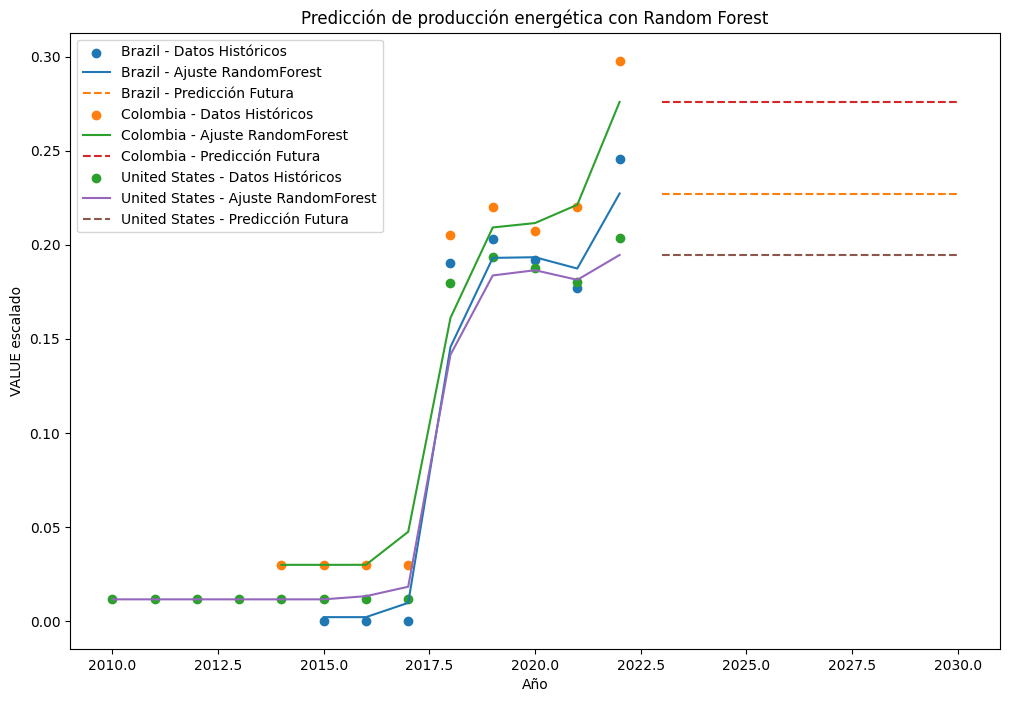

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Supongamos que 'df_filtered_scaled' ya contiene los datos escalados y las columnas originales.
# Aseguramos que solo se tengan datos de Colombia, Brazil y USA

# Convertir YEAR a entero (si no lo es)
df_filtered_scaled['YEAR'] = df_filtered_scaled['YEAR'].astype(int)

# Agregar datos por COUNTRY y YEAR: calculamos el promedio de VALUE para cada año
df_agg = df_filtered_scaled.groupby(['COUNTRY', 'YEAR'])['VALUE'].mean().reset_index()

# Diccionarios para almacenar modelos y predicciones
modelos = {}
predicciones = {}

# Definir los años futuros a predecir: desde el año máximo registrado hasta 2030
ano_maximo = df_agg['YEAR'].max()
anos_futuros = np.arange(ano_maximo + 1, 2031)

plt.figure(figsize=(12, 8))

# Iterar por cada país y entrenar un modelo Random Forest
for pais in df_agg['COUNTRY'].unique():
    df_pais = df_agg[df_agg['COUNTRY'] == pais]
    X = df_pais[['YEAR']]
    y = df_pais['VALUE']

    # Crear y entrenar el modelo de Random Forest
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X, y)
    modelos[pais] = modelo

    # Predicción sobre los datos históricos para visualizar el ajuste
    y_pred_hist = modelo.predict(X)

    # Predicción para los años futuros
    X_futuro = pd.DataFrame({'YEAR': anos_futuros})
    y_pred_futuro = modelo.predict(X_futuro)
    predicciones[pais] = pd.DataFrame({'YEAR': anos_futuros, 'Predicted_VALUE': y_pred_futuro})

    # Graficar los datos históricos y el ajuste
    plt.scatter(X, y, label=f'{pais} - Datos Históricos')
    plt.plot(X, y_pred_hist, label=f'{pais} - Ajuste RandomForest')
    # Graficar la predicción futura
    plt.plot(X_futuro, y_pred_futuro, '--', label=f'{pais} - Predicción Futura')

plt.xlabel("Año")
plt.ylabel("VALUE escalado")
plt.title("Predicción de producción energética con Random Forest")
plt.legend()
plt.show()


# Red Neuronal

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


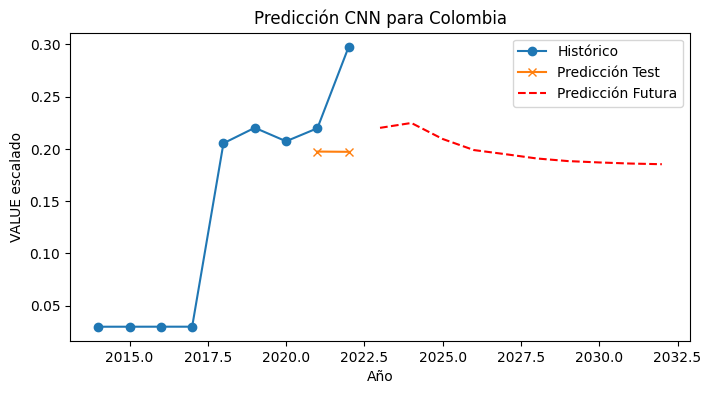

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


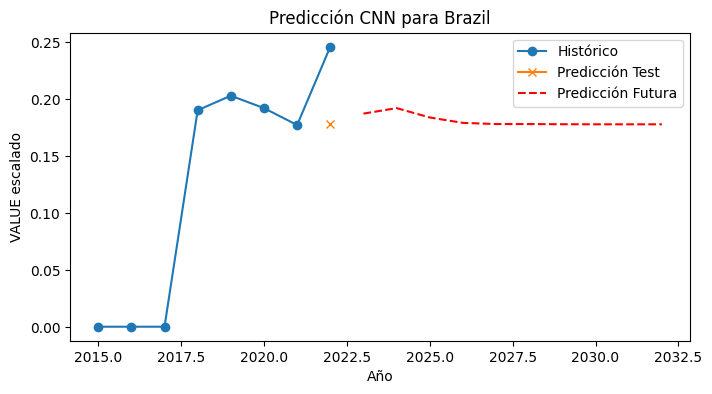

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


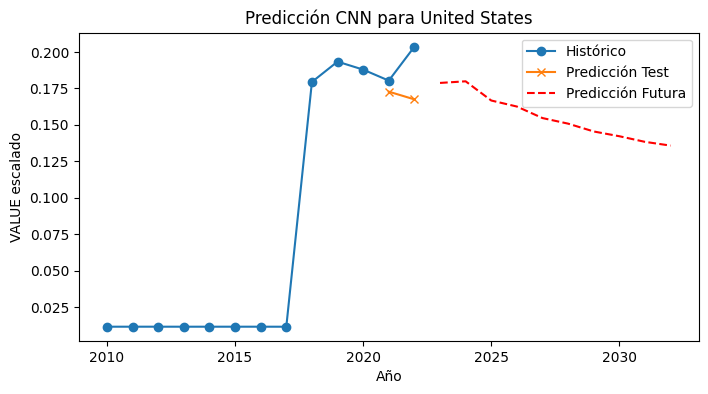

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Función para crear secuencias a partir de una serie temporal
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Parámetro: tamaño de la ventana (número de años previos para predecir el siguiente)
window_size = 3

# Suponemos que 'df_agg' contiene los datos agregados con columnas: COUNTRY, YEAR y VALUE
# Asegurarse de que los datos estén ordenados por año para cada país
paises = ['Colombia', 'Brazil', 'United States']
models = {}
predictions = {}

# Entrenar modelo para cada país
for country in paises:
    df_country = df_agg[df_agg['COUNTRY'] == country].sort_values('YEAR')
    series = df_country['VALUE'].values
    years = df_country['YEAR'].values

    # Verificar que existan suficientes datos para crear secuencias
    if len(series) <= window_size:
        print(f"No hay suficientes datos para {country} para usar una ventana de tamaño {window_size}")
        continue

    # Crear secuencias (X) y objetivos (y)
    X, y_seq = create_sequences(series, window_size)
    # Ajustar la forma para la CNN: (n_muestras, timesteps, n_features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Dividir en entrenamiento y prueba (ejemplo 80/20)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # Definir la arquitectura de la red neuronal convolucional
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # Capa de salida para regresión

    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=100, verbose=0)

    # Evaluar en el conjunto de prueba
    y_pred_test = model.predict(X_test)

    models[country] = model

    # Predicción futura: usar el último segmento conocido para predecir de forma iterativa
    last_sequence = series[-window_size:]
    future_years = []
    future_preds = []
    current_sequence = last_sequence.copy()
    num_future = 10  # Número de años futuros a predecir
    for i in range(num_future):
        # Predecir el siguiente valor
        pred = model.predict(current_sequence.reshape(1, window_size, 1))
        future_preds.append(pred[0,0])
        future_year = years[-1] + i + 1
        future_years.append(future_year)
        # Actualizar la secuencia: descartar el primer elemento y agregar la predicción
        current_sequence = np.append(current_sequence[1:], pred)

    predictions[country] = pd.DataFrame({'YEAR': future_years, 'Predicted_VALUE': future_preds})

    # Graficar resultados para el país
    plt.figure(figsize=(8, 4))
    plt.plot(years, series, 'o-', label='Histórico')
    # Graficar predicciones sobre el conjunto de prueba (a partir del punto donde se pueden comparar)
    test_years = years[split_idx + window_size:]
    plt.plot(test_years, y_pred_test, 'x-', label='Predicción Test')
    # Graficar predicción futura
    plt.plot(future_years, future_preds, 'r--', label='Predicción Futura')
    plt.title(f'Predicción CNN para {country}')
    plt.xlabel('Año')
    plt.ylabel('VALUE escalado')
    plt.legend()
    plt.show()


Creación de Secuencias:
La función create_sequences transforma la serie temporal en ventanas de tamaño definido para que la red pueda aprender la dependencia temporal.

Arquitectura de la CNN:
Se utiliza una red con una capa Conv1D, seguida de MaxPooling y capas densas. La capa de salida es una única neurona para regresión.

Predicción Futura:
Se utiliza la última ventana de datos para predecir iterativamente los próximos 10 años, actualizando la secuencia en cada paso.

Visualización:
Se grafican los datos históricos, las predicciones sobre el conjunto de prueba (si hay suficientes datos) y la proyección futura para cada país.

# Transición a Energías Renovables  

Estados Unidos, al igual que muchos otros países, está en una transición hacia fuentes de energía renovable. Esta transición puede implicar fluctuaciones en la producción total de energía, ya que la infraestructura para nuevas fuentes se desarrolla y las fuentes tradicionales se reducen gradualmente.  

La variabilidad de la producción de energías renovables (solar, eólica) podría influir en los datos, creando patrones que el modelo interpreta como una caída general.  

## Eficiencia Energética y Cambios en el Consumo  

- Los avances en eficiencia energética pueden reducir la demanda total de energía, lo que a su vez podría llevar a una menor producción.  
- Cambios en los patrones de consumo, como la adopción de vehículos eléctricos o la digitalización de la economía, también pueden influir en la demanda y, por lo tanto, en la producción.  

## Factores Económicos  

- Las fluctuaciones económicas, como recesiones o cambios en la actividad industrial, pueden afectar significativamente la demanda y la producción de energía.  
- Los precios de los combustibles fósiles también juegan un papel importante en la producción de energía.  

## Políticas Gubernamentales  

Las políticas relacionadas con la energía, como las regulaciones ambientales o los incentivos para las energías renovables, pueden tener un impacto significativo en la producción.  

## Avances Tecnológicos  

Nuevas tecnologías como la fusión nuclear o nuevas formas de energía podrían cambiar drásticamente la matriz energética.  


# Dashboard